<a href="https://colab.research.google.com/github/lucasjsgoncalves/classication_algo_olist/blob/main/algoritmos__de_classificacao_revenda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report,confusion_matrix,roc_curve, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier,RandomForestClassifier,BaggingClassifier,GradientBoostingClassifier


In [192]:
tabela = pd.read_csv('/content/drive/MyDrive/DATA/propensao_revenda_abt.csv')

#Vericaficando e ajustando os dados

In [193]:
tabela.head()

,data_ref_safra,seller_id,uf,tot_orders_12m,tot_items_12m,tot_items_dist_12m,receita_12m,recencia,nao_revendeu_next_6m
0,2018-01-01,0015a82c2db000af6aaaf3ae2ecb0532,SP,3,3,1,2685.00,74,1
1,2018-01-01,001cca7ae9ae17fb1caed9dfb1094831,ES,171,207,9,21275.23,2,0
2,2018-01-01,002100f778ceb8431b7a1020ff7ab48f,SP,38,42,15,781.80,2,0
3,2018-01-01,003554e2dce176b5555353e4f3555ac8,GO,1,1,1,120.00,16,1
4,2018-01-01,004c9cd9d87a3c30c522c48c4fc07416,SP,130,141,75,16228.88,8,0


In [194]:
tabela.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5369 entries, 0 to 5368
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   data_ref_safra        5369 non-null   object 
 1   seller_id             5369 non-null   object 
 2   uf                    5369 non-null   object 
 3   tot_orders_12m        5369 non-null   int64  
 4   tot_items_12m         5369 non-null   int64  
 5   tot_items_dist_12m    5369 non-null   int64  
 6   receita_12m           5369 non-null   float64
 7   recencia              5369 non-null   int64  
 8   nao_revendeu_next_6m  5369 non-null   int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 377.6+ KB


In [195]:
#Transformando variáveis categoricas em dummies
pd.get_dummies(tabela['uf'],dtype=int)

,AM,BA,CE,DF,ES,GO,MA,MG,MS,MT,...,PE,PI,PR,RJ,RN,RO,RS,SC,SE,SP
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5364,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5366,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
5367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [196]:
tabela = pd.concat([tabela,pd.get_dummies(tabela['uf'],dtype=int)],axis=1)

In [197]:
#Balaceando o número de 0 e 1 na tabela, para diminuir a possibilidade de underfitting ou overfitting
tabela_1= tabela[tabela['nao_revendeu_next_6m'] == 1]
tabela_0 = tabela[tabela['nao_revendeu_next_6m'] == 0]
tabela_balanceada = pd.concat([tabela_0.sample(len(tabela_1)),tabela_1], axis=0)
tabela = tabela_balanceada

In [198]:
tabela.columns

Index(['data_ref_safra', 'seller_id', 'uf', 'tot_orders_12m', 'tot_items_12m',
       'tot_items_dist_12m', 'receita_12m', 'recencia', 'nao_revendeu_next_6m',
       'AM', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MG', 'MS', 'MT', 'PA', 'PB',
       'PE', 'PI', 'PR', 'RJ', 'RN', 'RO', 'RS', 'SC', 'SE', 'SP'],
      dtype='object')

In [199]:
#Normalizando os valores para que números em diferentes escalas possam ser usados de maneira apropriada
escalador = MinMaxScaler()
x = escalador.fit_transform(tabela[['tot_orders_12m', 'tot_items_12m',
       'tot_items_dist_12m', 'receita_12m', 'recencia',
       'AM', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MG', 'MS', 'MT', 'PA', 'PB',
       'PE', 'PI', 'PR', 'RJ', 'RN', 'RO', 'RS', 'SC', 'SE', 'SP']].values)

In [200]:
x

array([[0.00814815, 0.00925926, 0.00321543, ..., 0.        , 0.        ,
        0.        ],
       [0.00814815, 0.00783476, 0.01607717, ..., 0.        , 0.        ,
        0.        ],
       [0.00222222, 0.00213675, 0.00643087, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.00444444, 0.0042735 , 0.00643087, ..., 0.        , 0.        ,
        1.        ],
       [0.00222222, 0.00213675, 0.00643087, ..., 0.        , 0.        ,
        0.        ]])

In [201]:
y = tabela['nao_revendeu_next_6m'].values

In [202]:
tabela['nao_revendeu_next_6m'].value_counts()

,count
nao_revendeu_next_6m,
0,2053
1,2053


In [203]:
tabela[tabela['nao_revendeu_next_6m'] == 0].sample(2053)

,data_ref_safra,seller_id,uf,tot_orders_12m,tot_items_12m,tot_items_dist_12m,receita_12m,recencia,nao_revendeu_next_6m,AM,...,PE,PI,PR,RJ,RN,RO,RS,SC,SE,SP
697,2018-01-01,6861de0f40cacb0602e473c51639f980,PR,1,1,1,499.00,43,0,0,...,0,0,1,0,0,0,0,0,0,0
3776,2018-03-01,259f7b5e6e482c230e5bfaa670b6bb8f,SP,92,111,22,5686.74,0,0,0,...,0,0,0,0,0,0,0,0,0,1
249,2018-01-01,23613d49c3ac2bd302259e55c06c050c,SP,35,38,19,2411.20,14,0,0,...,0,0,0,0,0,0,0,0,0,1
4966,2018-03-01,c7fdb77fdbff3c41981bc52f787e959e,SP,4,5,3,406.50,23,0,0,...,0,0,0,0,0,0,0,0,0,1
2372,2018-02-01,5f1dc28029d2c244352a68107ec2b542,SP,44,54,32,2179.80,2,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3937,2018-03-01,3c487ae8f8d7542beff5788e2e0aea83,DF,13,16,9,5131.40,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1394,2018-01-01,d1c281d3ae149232351cd8c8cc885f0d,SP,158,179,93,19990.21,4,0,0,...,0,0,0,0,0,0,0,0,0,1
3594,2018-03-01,0be8ff43f22e456b4e0371b2245e4d01,SP,96,108,72,7002.60,12,0,0,...,0,0,0,0,0,0,0,0,0,1
1384,2018-01-01,cfb1a033743668a192316f3c6d1d2671,SP,100,125,44,9254.89,3,0,0,...,0,0,0,0,0,0,0,0,0,1


In [204]:
y

array([0, 0, 0, ..., 1, 1, 1])

In [205]:
#Dividindo a base entre treino e teste
x_treino, x_teste, y_treino, y_teste = train_test_split(x,y,train_size=0.7)

#Modelagem com diferentes algoritmos

##Árvore de Decisão

In [206]:
modelo = DecisionTreeClassifier(max_depth=4,min_samples_leaf=10)
modelo.fit(x_treino,y_treino)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=10)

In [207]:
modelo.predict(x_teste)

array([1, 0, 0, ..., 1, 1, 0])

In [208]:
y_treino

array([1, 0, 0, ..., 0, 1, 0])

In [209]:
comparacao =pd.DataFrame( data = {'real':y_teste,
    'prev':modelo.predict(x_teste)})

In [210]:
comparacao.head()

,real,prev
0,0,1
1,0,0
2,1,0
3,1,1
4,0,0


In [211]:
comparacao['acerto'] = comparacao['real'] == comparacao['prev']

In [212]:
comparacao.pivot_table(index='real',columns='prev',values='acerto',aggfunc='count')

prev,0,1
real,,
0,504,130
1,110,488


In [213]:
modelo.score(x_teste,y_teste)



0.8051948051948052

In [214]:
modelo.score(x_treino,y_treino)

0.8364648573416841

[Text(0.5, 0.9, 'recencia <= 0.111\ngini = 0.5\nsamples = 2874\nvalue = [1419.0, 1455.0]'),
 Text(0.25, 0.7, 'tot_orders_12m <= 0.002\ngini = 0.294\nsamples = 1421\nvalue = [1167.0, 254.0]'),
 Text(0.375, 0.8, 'True  '),
 Text(0.125, 0.5, 'recencia <= 0.095\ngini = 0.484\nsamples = 318\nvalue = [187, 131]'),
 Text(0.0625, 0.3, 'receita_12m <= 0.001\ngini = 0.469\nsamples = 283\nvalue = [177, 106]'),
 Text(0.03125, 0.1, 'gini = 0.497\nsamples = 84\nvalue = [39, 45]'),
 Text(0.09375, 0.1, 'gini = 0.425\nsamples = 199\nvalue = [138, 61]'),
 Text(0.1875, 0.3, 'recencia <= 0.104\ngini = 0.408\nsamples = 35\nvalue = [10, 25]'),
 Text(0.15625, 0.1, 'gini = 0.32\nsamples = 25\nvalue = [5, 20]'),
 Text(0.21875, 0.1, 'gini = 0.5\nsamples = 10\nvalue = [5, 5]'),
 Text(0.375, 0.5, 'recencia <= 0.059\ngini = 0.198\nsamples = 1103\nvalue = [980, 123]'),
 Text(0.3125, 0.3, 'tot_orders_12m <= 0.009\ngini = 0.13\nsamples = 905\nvalue = [842, 63]'),
 Text(0.28125, 0.1, 'gini = 0.24\nsamples = 287\nvalue

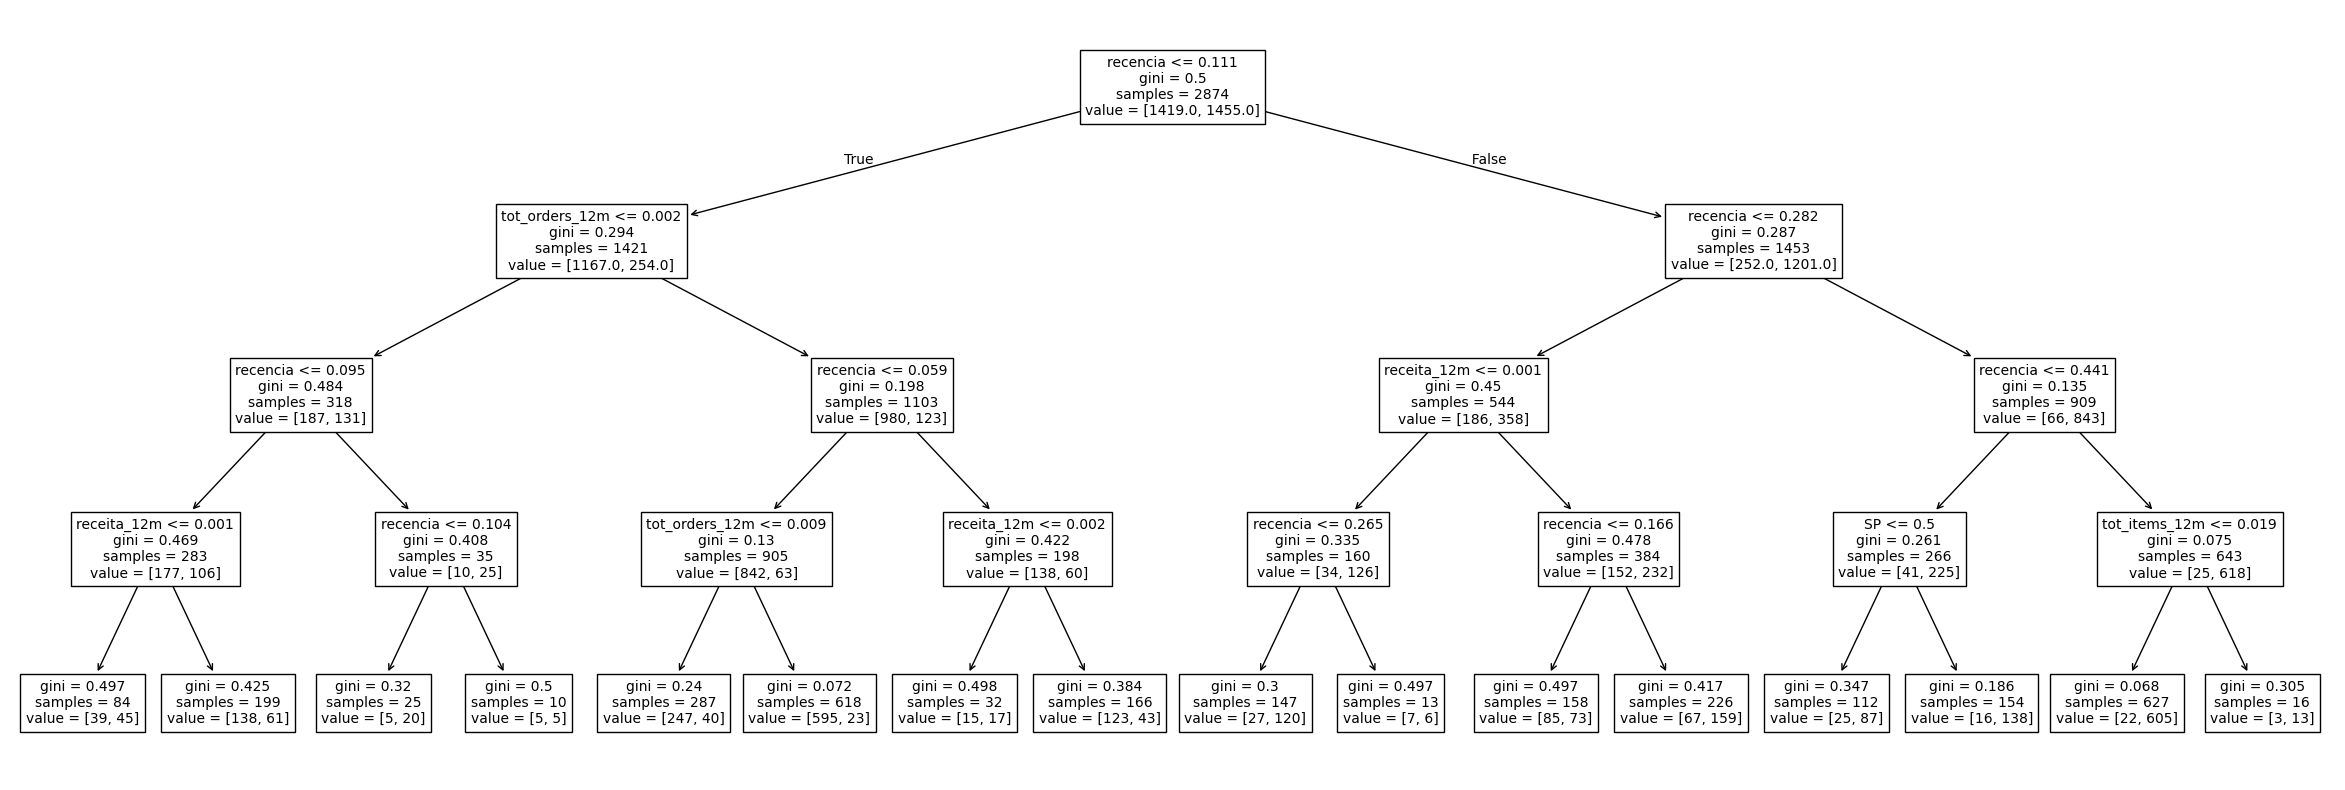

In [215]:
plt.figure(figsize=(30,10))
plot_tree(modelo,fontsize=10, feature_names=['tot_orders_12m', 'tot_items_12m',
       'tot_items_dist_12m', 'receita_12m', 'recencia',
       'AM', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MG', 'MS', 'MT', 'PA', 'PB',
       'PE', 'PI', 'PR', 'RJ', 'RN', 'RO', 'RS', 'SC', 'SE', 'SP'])

In [216]:
modelo.get_depth()

4

In [217]:
list_zeros = np.zeros((1,27))

In [218]:
list_zeros[0][4] = 0.144

In [219]:
escalador.inverse_transform(list_zeros)

array([[ 1.   ,  1.   ,  1.   ,  6.   , 52.416,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ]])

In [220]:
print(classification_report(y_teste,modelo.predict(x_teste)))

              precision    recall  f1-score   support

           0       0.82      0.79      0.81       634
           1       0.79      0.82      0.80       598

    accuracy                           0.81      1232
   macro avg       0.81      0.81      0.81      1232
weighted avg       0.81      0.81      0.81      1232



In [221]:
confusion_matrix(y_teste,modelo.predict(x_teste))

array([[504, 130],
       [110, 488]])

In [222]:
(roc_curve(y_teste,modelo.predict_proba(x_teste).max(axis=1)))

(array([0.        , 0.01735016, 0.40536278, 0.41955836, 0.59305994,
        0.62460568, 0.62460568, 0.63722397, 0.64511041, 0.73028391,
        0.79022082, 0.88012618, 0.88328076, 0.93375394, 0.97634069,
        0.99526814, 1.        ]),
 array([0.        , 0.43812709, 0.45819398, 0.56187291, 0.59197324,
        0.66555184, 0.67056856, 0.67892977, 0.7458194 , 0.77759197,
        0.86287625, 0.90133779, 0.909699  , 0.96153846, 0.98494983,
        0.99665552, 1.        ]),
 array([       inf, 0.96491228, 0.96278317, 0.8961039 , 0.86062718,
        0.81632653, 0.8125    , 0.8       , 0.77678571, 0.74096386,
        0.70353982, 0.69346734, 0.53846154, 0.53797468, 0.53571429,
        0.53125   , 0.5       ]))

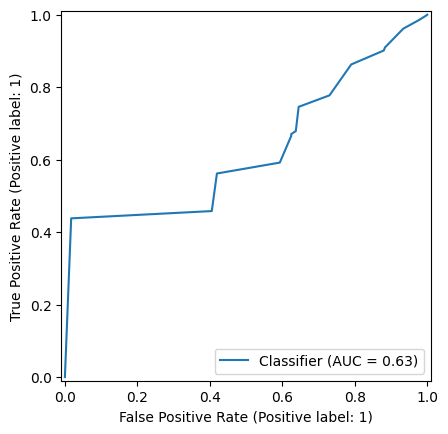

In [223]:
RocCurveDisplay.from_predictions(y_teste,modelo.predict_proba(x_teste).max(axis=1))

##Regressão Logística


In [224]:
regressao = LogisticRegression()
regressao.fit(x_treino,y_treino)

LogisticRegression()

In [225]:
print(classification_report(y_treino,regressao.predict(x_treino)))

              precision    recall  f1-score   support

           0       0.77      0.89      0.83      1419
           1       0.87      0.75      0.80      1455

    accuracy                           0.82      2874
   macro avg       0.82      0.82      0.82      2874
weighted avg       0.82      0.82      0.82      2874



In [226]:
print(classification_report(y_teste,regressao.predict(x_teste)))

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       634
           1       0.87      0.74      0.80       598

    accuracy                           0.82      1232
   macro avg       0.83      0.82      0.82      1232
weighted avg       0.83      0.82      0.82      1232



##Ensemble

In [227]:
modelo_ensemble = DecisionTreeClassifier(max_depth=4,min_samples_leaf=10)
regressao_ensemble = LogisticRegression()


ensemble = VotingClassifier([('arvore',modelo_ensemble),('regressao',regressao_ensemble)],voting='soft')

In [228]:
ensemble.fit(x_treino,y_treino)

VotingClassifier(estimators=[('arvore',
                              DecisionTreeClassifier(max_depth=4,
                                                     min_samples_leaf=10)),
                             ('regressao', LogisticRegression())],
                 voting='soft')

In [229]:
print(classification_report(y_treino,ensemble.predict(x_treino)))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84      1419
           1       0.87      0.79      0.83      1455

    accuracy                           0.83      2874
   macro avg       0.84      0.83      0.83      2874
weighted avg       0.84      0.83      0.83      2874



In [230]:
print(classification_report(y_teste,ensemble.predict(x_teste)))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       634
           1       0.84      0.79      0.81       598

    accuracy                           0.82      1232
   macro avg       0.82      0.82      0.82      1232
weighted avg       0.82      0.82      0.82      1232



##Random Forest

In [231]:
floresta = RandomForestClassifier(n_estimators=103,max_depth=5,min_samples_leaf=11)

In [232]:
floresta.fit(x_treino,y_treino)

RandomForestClassifier(max_depth=5, min_samples_leaf=11, n_estimators=103)

In [233]:
print(classification_report(y_teste,floresta.predict(x_teste)))

              precision    recall  f1-score   support

           0       0.84      0.76      0.80       634
           1       0.77      0.85      0.81       598

    accuracy                           0.80      1232
   macro avg       0.81      0.80      0.80      1232
weighted avg       0.81      0.80      0.80      1232



In [234]:
print(classification_report(y_treino,floresta.predict(x_treino)))

              precision    recall  f1-score   support

           0       0.86      0.80      0.83      1419
           1       0.81      0.87      0.84      1455

    accuracy                           0.83      2874
   macro avg       0.84      0.83      0.83      2874
weighted avg       0.84      0.83      0.83      2874



##Ensemble - Random Regressão Logística

In [235]:
ensemble_rl= BaggingClassifier(estimator=LogisticRegression(),n_estimators=18)

In [236]:
ensemble_rl.fit(x_treino,y_treino)

BaggingClassifier(estimator=LogisticRegression(), n_estimators=18)

In [237]:
print(classification_report(y_treino,ensemble_rl.predict(x_treino)))

              precision    recall  f1-score   support

           0       0.77      0.89      0.83      1419
           1       0.87      0.75      0.80      1455

    accuracy                           0.82      2874
   macro avg       0.82      0.82      0.82      2874
weighted avg       0.82      0.82      0.82      2874



In [238]:
print(classification_report(y_teste,ensemble.predict(x_teste)))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       634
           1       0.84      0.79      0.81       598

    accuracy                           0.82      1232
   macro avg       0.82      0.82      0.82      1232
weighted avg       0.82      0.82      0.82      1232



##Gradient Boosting

In [239]:
gradientboost= GradientBoostingClassifier()

In [240]:
gradientboost.fit(x_treino,y_treino)

GradientBoostingClassifier()

In [241]:
print(classification_report(y_treino,gradientboost.predict(x_treino)))

              precision    recall  f1-score   support

           0       0.86      0.87      0.86      1419
           1       0.87      0.86      0.87      1455

    accuracy                           0.86      2874
   macro avg       0.86      0.86      0.86      2874
weighted avg       0.86      0.86      0.86      2874



In [242]:
print(classification_report(y_teste,gradientboost.predict(x_teste)))

              precision    recall  f1-score   support

           0       0.85      0.81      0.83       634
           1       0.81      0.84      0.83       598

    accuracy                           0.83      1232
   macro avg       0.83      0.83      0.83      1232
weighted avg       0.83      0.83      0.83      1232



#Conclusão
Todos os modelos apresentaram métricas muito semelhantes, como F1-score e acurácia. Nesse caso, a árvore de decisão é a melhor escolha, pois oferece explicações mais simples e intuitivas, facilitando a interpretação e a comunicação dos resultados.